# Analyze Health Data

-----

## Backlog

- Add CI and code coverage to my git repos
- Calories
- Bar charts with steps/workouts side by side
- Aggregate stairmaster, eliptical, rower, etc...
- Ideally create single merged data table of daily fitness stats
- Integrate w/strava
- Need strava data to get calories from cycling workouts I think.
- Add vertical lines to mark surgery & novo start dates
- Mindfulness minutes
- VO2max
- Reevaluate SPM outlier removal (de-automate, manually remove true errors if needed)
- Number of workouts of each type (run/bike/swim/etc...)

## Dependencies and Libraries

In [1]:
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm
import seaborn as sns
%matplotlib inline

## Data Extraction

In [2]:
## Can I pass any path to the argument below? If so I will no longer have to move the export file...

%run -i 'apple-health-data-parser' 'data/export.xml'

Reading data from data/export.xml . . . done


apple-health-data-parser.py:136: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  self.nodes = self.root.getchildren()


Unexpected node of type ExportDate.

Tags:
ActivitySummary: 893
ExportDate: 1
Me: 1
Record: 3082143
Workout: 601

Fields:
HKCharacteristicTypeIdentifierBiologicalSex: 1
HKCharacteristicTypeIdentifierBloodType: 1
HKCharacteristicTypeIdentifierCardioFitnessMedicationsUse: 1
HKCharacteristicTypeIdentifierDateOfBirth: 1
HKCharacteristicTypeIdentifierFitzpatrickSkinType: 1
activeEnergyBurned: 893
activeEnergyBurnedGoal: 893
activeEnergyBurnedUnit: 893
appleExerciseTime: 893
appleExerciseTimeGoal: 893
appleMoveTime: 893
appleMoveTimeGoal: 893
appleStandHours: 893
appleStandHoursGoal: 893
creationDate: 3082744
dateComponents: 893
device: 2977702
duration: 601
durationUnit: 601
endDate: 3082744
sourceName: 3082744
sourceVersion: 3070605
startDate: 3082744
totalDistance: 601
totalDistanceUnit: 601
totalEnergyBurned: 601
totalEnergyBurnedUnit: 601
type: 3082143
unit: 3066092
value: 3081880
workoutActivityType: 601

Record types:
ActiveEnergyBurned: 1170573
AppleExerciseTime: 62498
AppleStandHour

------

# Steps

In [3]:
steps = pd.read_csv("data/StepCount.csv")

# parse out date and time elements as EST time
steps['startDate'] = pd.to_datetime(steps['startDate'], utc=True).dt.tz_convert('EST')
steps['endDate'] = pd.to_datetime(steps['endDate'], utc=True).dt.tz_convert('EST')
steps['date'] = steps['startDate'].dt.strftime('%Y-%m-%d')
steps['doy'] = steps['startDate'].dt.dayofyear

#drop irrelevant columns
steps = steps.drop(['device', 'creationDate', 'type', 'unit', 'sourceVersion'], axis=1)

#sort
steps = steps.sort_values(['startDate'])

### Import and Merge Fitbit data

In [4]:
# Read fitbit csv
fb = pd.read_csv('data/fitbit_master.csv')

# parse out date and time elements as EST time
fb['Date'] = pd.to_datetime(fb['Date'])#.dt.tz_convert('EST')
fb['date'] = fb['Date'].dt.strftime('%Y-%m-%d')
fb['sourceName'] = 'FitBit'
fb2=fb[['sourceName','date', 'Steps']]

# Aggregate apple watch data by date
steps_by_dateX = steps.groupby(['sourceName','date'])['value'].sum().reset_index(name='Steps')

#merge with fitbit data
steps_by_dateX = pd.concat([fb2, steps_by_dateX], ignore_index=True)

# print(steps_by_dateX.tail())

### Clean Daily Steps Data

In [5]:
#sort and drop lowest
steps_by_dateX = steps_by_dateX.sort_values(['date', 'Steps'])
steps_by_dateX = steps_by_dateX.drop_duplicates('date', keep='last').reset_index(drop=True)
steps_by_date = steps_by_dateX.drop('sourceName', axis=1)
print(steps_by_date.tail(10))

            date  Steps
1471  2020-11-11   1404
1472  2020-11-12   3224
1473  2020-11-13  10138
1474  2020-11-14   6130
1475  2020-11-15  24450
1476  2020-11-16   2587
1477  2020-11-17  11573
1478  2020-11-18  13912
1479  2020-11-19   4330
1480  2020-11-20   8725


### Histogram of Steps

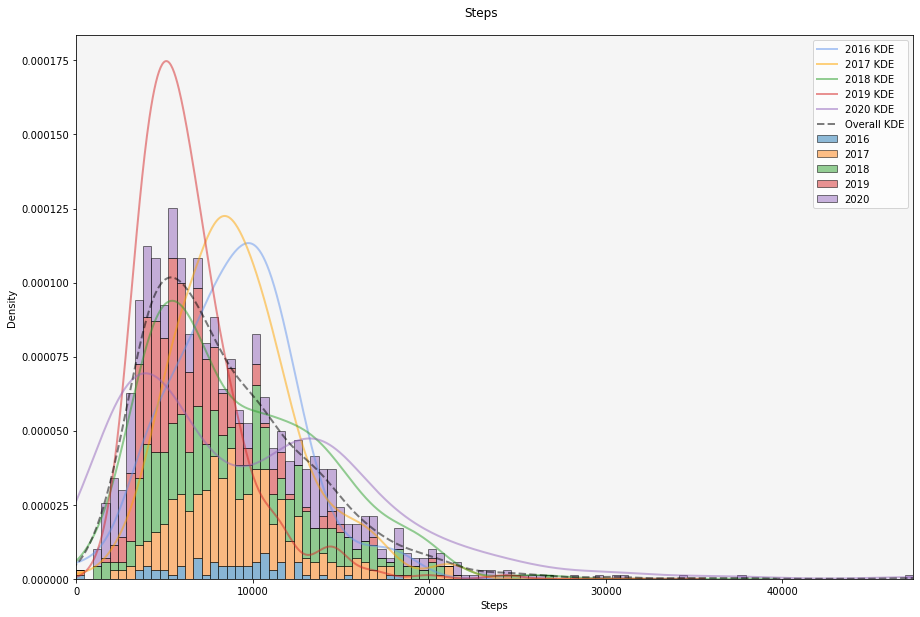

In [6]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])

#Specify distribution parameters
bn = 100

#plot histogram of steps
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
n, bins, patches = plt.hist([df[df.date.dt.year==2016].Steps,df[df.date.dt.year==2017].Steps,df[df.date.dt.year==2018].Steps,df[df.date.dt.year==2019].Steps, df[df.date.dt.year==2020].Steps], bn, density=True, alpha =0.5, histtype='barstacked', label=['2016', '2017', '2018', '2019', '2020'], edgecolor='black')

df[df.date.dt.year==2016].Steps.plot.kde(c='cornflowerblue', alpha = 0.5, linewidth=2, label = '2016 KDE')
df[df.date.dt.year==2017].Steps.plot.kde(c= 'orange', alpha = 0.5, linewidth=2, label = '2017 KDE')
df[df.date.dt.year==2018].Steps.plot.kde(c='tab:green', alpha = 0.5, linewidth=2, label = '2018 KDE')
df[df.date.dt.year==2019].Steps.plot.kde(c='tab:red', alpha = 0.5, linewidth=2, label = '2019 KDE')
df[df.date.dt.year==2020].Steps.plot.kde(c='tab:purple', alpha = 0.5, linewidth=2, label = '2020 KDE')
df.Steps.plot.kde(c='k', alpha = 0.5, linewidth=2, linestyle='dashed', label = 'Overall KDE')

plt.xlim((0,df.Steps.max()))
plt.xlabel('Steps')
plt.legend(loc=1)
plt.show()

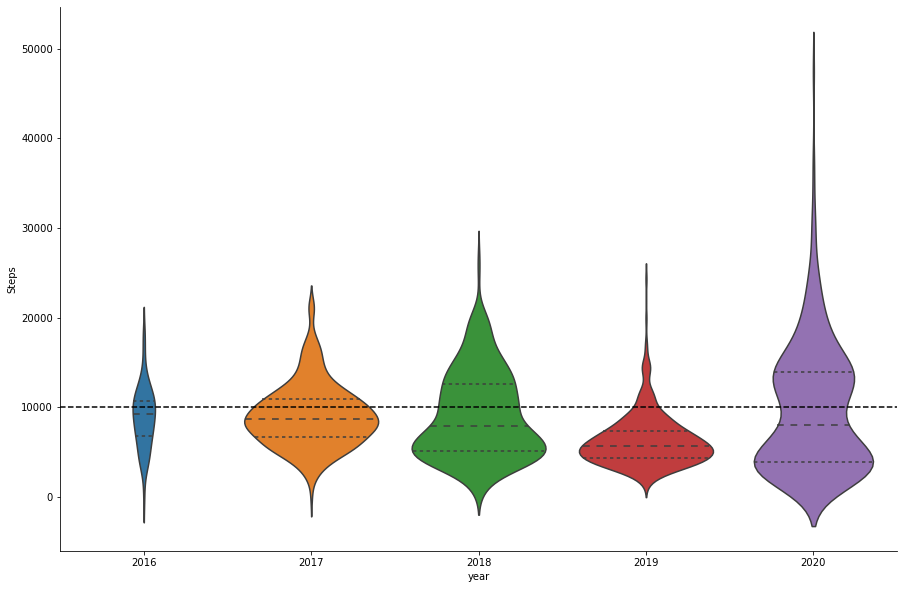

In [7]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
plt.figure(figsize=(15,10))
sns.violinplot(x='year', y='Steps', data=df, inner="quart", scale='count')
sns.despine(left=False)
plt.axhline(10000, color='k', linestyle='dashed')

### Rolling average

In [8]:
steps_by_date2=steps_by_date.copy()
steps_by_date2['date'] = pd.to_datetime(steps_by_date2['date'])
steps_by_date2['days_elapsed'] = (steps_by_date2['date']-steps_by_date2['date'].min()).dt.days +1
steps_by_date2['steps_expected'] = steps_by_date2['days_elapsed']*10000
steps_by_date2['steps_total'] = steps_by_date2['Steps'].cumsum()
steps_by_date2['steps_deficit'] = steps_by_date2['steps_expected'] - steps_by_date2['steps_total']
steps_by_date2=steps_by_date2.set_index('date')
print('I have made up {:,} steps since my largest deficit on {}'\
      .format((steps_by_date2.iloc[steps_by_date2.steps_deficit.argmax()].steps_deficit\
               - steps_by_date2.steps_deficit[-1])\
              , list(steps_by_date2.index)[steps_by_date2.steps_deficit.argmax()].strftime('%Y-%m-%d')))

I have made up 438,051 steps since my largest deficit on 2020-04-13


In [9]:
# plt.figure(figsize=[15,10])
# ax = plt.gca()
# ax.set_facecolor('whitesmoke')
# plt.suptitle('Steps', fontsize=12, y=.92)
# plt.grid(True)
# plt.plot(steps_by_date2['Steps'], 'r.', alpha=0.2,label='Steps')
# plt.plot(steps_by_date2.Steps.rolling(window=7, center=False).mean(), c='k',label='7 day rolling average', alpha=0.75)
# plt.plot(steps_by_date2.Steps.rolling(window=365, center=False).mean(), c='blue', label='1-yr rolling avg', alpha =0.75)

# ax.axhline(10000, linewidth=2, color='k', linestyle='dashed',label="10,000 per day")
# ax.axhline(steps_by_date2.Steps.mean(), linewidth=2, color='blue', linestyle='dashed',label="Global avg steps per day")

# plt.hlines(steps_by_date2.resample('Y').mean()\
#            .iloc[0,0],steps_by_date2.index.min(), steps_by_date2.resample('Y').mean()\
#            .index[0], colors=(1,0,0,1), linewidths=(5,))
# plt.hlines(steps_by_date2.resample('Y').mean()\
#            .iloc[1,0],steps_by_date2.resample('Y').mean().index[0],\
#            steps_by_date2.resample('Y').mean().index[1], colors=(1,0.5,0,1), linewidths=(5,))
# plt.hlines(steps_by_date2.resample('Y').mean()\
#            .iloc[2,0],steps_by_date2.resample('Y').mean().index[1],\
#            steps_by_date2.resample('Y').mean().index[2], colors=(1,1,0,1), linewidths=(5,))
# plt.hlines(steps_by_date2.resample('Y').mean()\
#            .iloc[3,0],steps_by_date2.resample('Y').mean().index[2],\
#            steps_by_date2.resample('Y').mean().index[3], colors=(0.5,1,0,1), linewidths=(5,))
# plt.hlines(steps_by_date2.resample('Y').mean()\
#            .iloc[4,0],steps_by_date2.resample('Y').mean().index[3],\
#            steps_by_date2.index.max(), colors=(0,1,1,1), linewidths=(5,))
# plt.legend(loc=2)
# plt.xticks(rotation=45)
# plt.show()

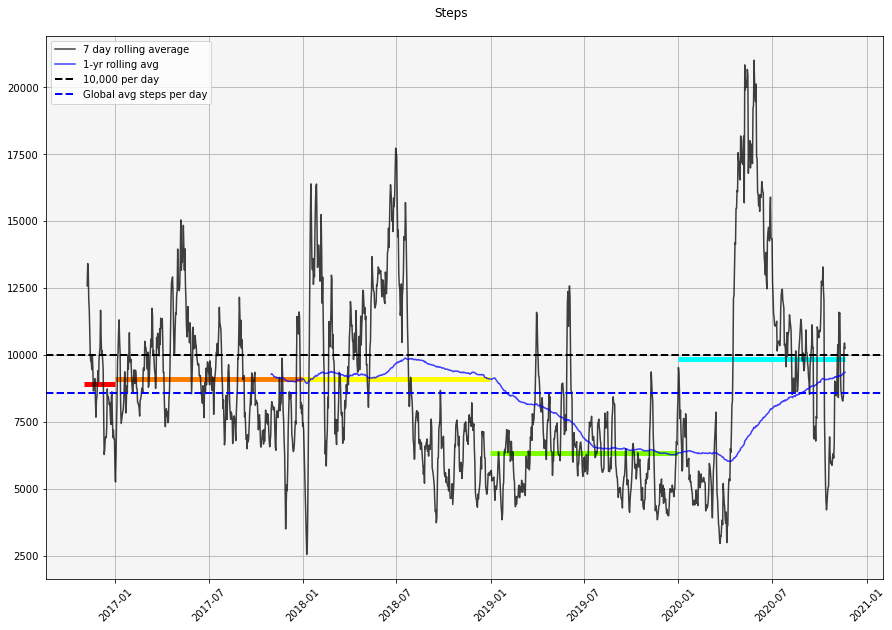

In [10]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
plt.grid(True)
# plt.plot(steps_by_date2['Steps'], 'r.', alpha=0.2,label='Steps')
plt.plot(steps_by_date2.Steps.rolling(window=7, center=False).mean(), c='k',label='7 day rolling average', alpha=0.75)
plt.plot(steps_by_date2.Steps.rolling(window=365, center=False).mean(), c='blue', label='1-yr rolling avg', alpha =0.75)

ax.axhline(10000, linewidth=2, color='k', linestyle='dashed',label="10,000 per day")
ax.axhline(steps_by_date2.Steps.mean(), linewidth=2, color='blue', linestyle='dashed',label="Global avg steps per day")

plt.hlines(steps_by_date2.resample('Y').mean()\
           .iloc[0,0],steps_by_date2.index.min(), steps_by_date2.resample('Y').mean()\
           .index[0], colors=(1,0,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean()\
           .iloc[1,0],steps_by_date2.resample('Y').mean().index[0],\
           steps_by_date2.resample('Y').mean().index[1], colors=(1,0.5,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean()\
           .iloc[2,0],steps_by_date2.resample('Y').mean().index[1],\
           steps_by_date2.resample('Y').mean().index[2], colors=(1,1,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean()\
           .iloc[3,0],steps_by_date2.resample('Y').mean().index[2],\
           steps_by_date2.resample('Y').mean().index[3], colors=(0.5,1,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean()\
           .iloc[4,0],steps_by_date2.resample('Y').mean().index[3],\
           steps_by_date2.index.max(), colors=(0,1,1,1), linewidths=(5,))
plt.legend(loc=2)
plt.xticks(rotation=45)
plt.show()

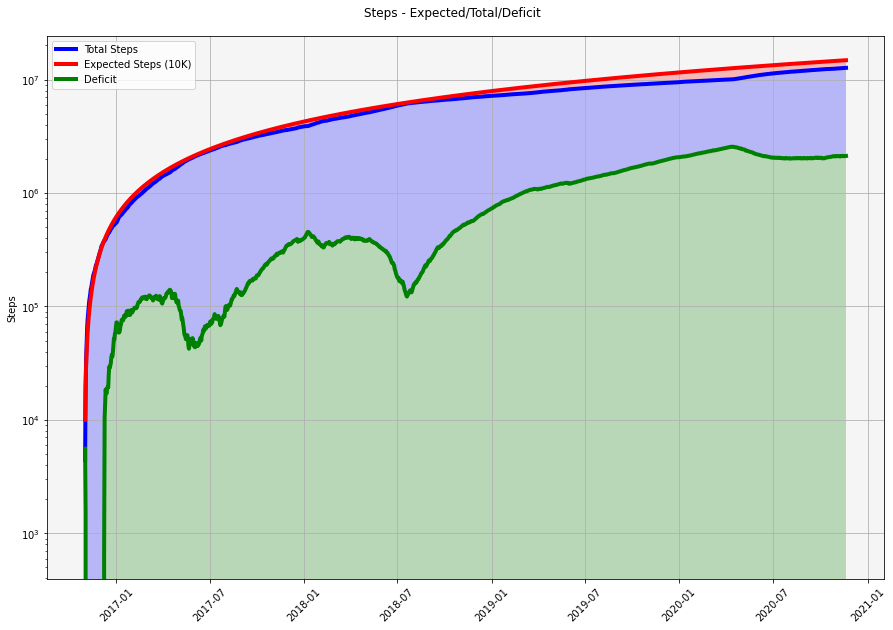

My current deficit is 2,121,194 steps


In [11]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps - Expected/Total/Deficit', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_date2['steps_total'], alpha=1,label='Total Steps', linewidth=4, c='blue')
plt.plot(steps_by_date2['steps_expected'], alpha=1,label='Expected Steps (10K)', linewidth=4, c='r')
plt.plot(steps_by_date2['steps_deficit'], alpha=1,label='Deficit', linewidth=4, c='green')
ax.fill_between(steps_by_date2.index,steps_by_date2['steps_total'], steps_by_date2['steps_deficit'], facecolor='blue', alpha=0.25)
ax.fill_between(steps_by_date2.index,steps_by_date2['steps_expected'], steps_by_date2['steps_total'], facecolor='r', alpha=0.25)
ax.fill_between(steps_by_date2.index, steps_by_date2['steps_deficit'], facecolor='green', alpha=0.25)
plt.yscale('log')
plt.ylabel("Steps")
plt.legend(loc=2)
plt.xticks(rotation=45)
plt.show()

print('My current deficit is {:,} steps'.format(steps_by_date2.steps_deficit[-1]))

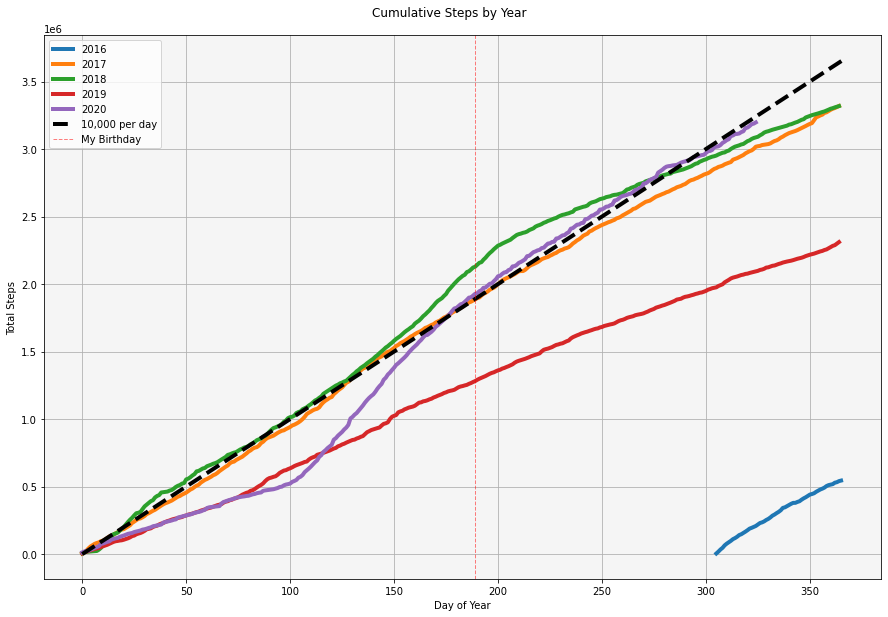

In [12]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['doy'] = df['date'].dt.dayofyear

steps_by_year = pd.pivot_table(df, index='doy', columns='year', values='Steps'\
                               , aggfunc='sum').reset_index().rename_axis(None, axis=1)

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Cumulative Steps by Year', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_year[2016].cumsum(), label='2016', linewidth=4)
plt.plot(steps_by_year[2017].cumsum(), label='2017', linewidth=4)
plt.plot(steps_by_year[2018].cumsum(), label='2018', linewidth=4)
plt.plot(steps_by_year[2019].cumsum(), label='2019', linewidth=4)
plt.plot(steps_by_year[2020].cumsum(), label='2020', linewidth=4)
x1, y1 = [0,366], [0,3660000]
plt.plot(x1,y1, linewidth = 4, linestyle='dashed', c='k', label="10,000 per day")
ax.axvline(189, linewidth=1, color='r', linestyle='dashed', alpha=0.5, label="My Birthday")
plt.ylabel("Total Steps")
plt.xlabel("Day of Year")
plt.legend(loc=2)
plt.show()

In [13]:
#Fix b-day stuff



### Steps needed to get on track

#Yearly averages
yearly_totals = steps_by_date.copy()
yearly_totals['date']=pd.to_datetime(yearly_totals['date'])
yearly_totals=yearly_totals.set_index('date')
yearly_totals =yearly_totals['Steps'].resample('Y').sum()
# print(yearly_totals)

# Calc 7-day rolling mean
zz = steps_by_date.copy()
zz['date']=pd.to_datetime(zz['date'])
zz=zz.set_index('date')
rolling7 = math.floor(zz.iloc[-7:].Steps.mean())

#Current DOY
doy = datetime.today().timetuple().tm_yday#.strftime('%Y-%m-%d')

#My birthday doy
bday_doy = pd.to_datetime('2020-07-07').dayofyear


###################
#Start output
###################


print("Today is the {}th day of {} and I am currently averaging {:,} steps per day (SPD) for the year.\n"\
      .format(doy, yearly_totals.index[-1].year, math.ceil(yearly_totals.iloc[-1]/doy)))

if (doy*10000-yearly_totals.iloc[-1])>0:
    print("I am {:,} steps behind what I need to be at a 10,000 SPD average."\
          .format((doy*10000-yearly_totals.iloc[-1])))
    print("This is equivalent to being {} days behind.".format(round((doy*10000-yearly_totals.iloc[-1])/10000, 1)))
    print("To reach 10,000 SPD I will need to walk {:,} SPD for the rest of the year."\
          .format(math.ceil((3652500-yearly_totals.iloc[-1])/(365.25-doy))))
    print("To reach 10,000 SPD by my birthday I will need to walk {:,} SPD for the next {} days."\
          .format(round(((bday_doy*10000)-yearly_totals.iloc[-1])/(bday_doy-doy), 1),\
              (bday_doy-doy)))
    print("At my current 7-day average of {:,} I will hit my 10,000 spd average in {} days\n"\
          .format(rolling7, round((doy*10000-yearly_totals.iloc[-1])/(rolling7-10000),1)))
else:
    print("I am {:,} steps ahead of what I need to be at a 10,000 SPD average."\
          .format((yearly_totals.iloc[-1]-doy*10000)))
    print("This is equivalent to being {} days ahead."\
          .format(round((yearly_totals.iloc[-1]-doy*10000)/10000, 1)))
    print("To maintain at least 10,000 SPD I will need to walk {:,} SPD for the rest of the year.\n"\
          .format(math.ceil((3652500-yearly_totals.iloc[-1])/(365.25-doy))))

    
print("My global average is {:,} SPD.".format(round(steps_by_date2.Steps.mean(),1)))
if yearly_totals.iloc[-1]/doy < steps_by_date2.Steps.mean():
    print("I need to make up {:,} steps for my current SPD to match the global average."\
      .format(math.ceil((steps_by_date2.Steps.mean()-yearly_totals.iloc[-1]/doy)*doy)))
print("To beat my global average I will need to walk at least {:,} SPD for the rest of the year."\
      .format(math.ceil(((steps_by_date2.Steps.mean()*365.25)-yearly_totals.iloc[-1])/(365.25-doy))))
print("I need to walk {} extra steps to raise my global average by 1 step."\
      .format((steps_by_date2.index[-1]-steps_by_date2.index[0]).days))
print("To reach a global average of 9,000 SPD I need to make up {:,} steps."\
      .format(steps_by_date2.shape[0]*9000-steps_by_date2.Steps.sum()))
print("To reach a global average of 10,000 SPD I need to make up {:,} steps, which is equivalent to {} days."\
      .format(steps_by_date2.shape[0]*10000-steps_by_date2.Steps.sum(),\
              round((steps_by_date2.shape[0]*10000-steps_by_date2.Steps.sum())/10000,1)))

if(rolling7>10000):
    print("At my current 7-day average of {:,} I will hit a global 9,000 spd average in {} days on {}."\
      .format(rolling7,\
              round((steps_by_date2.shape[0]*9000-steps_by_date2.Steps.sum())/(rolling7-9000),1),\
             (datetime.today()+ td(days=(steps_by_date2.shape[0]*9000-steps_by_date2.Steps.sum())/(rolling7-9000)))\
              .strftime('%Y-%m-%d')))
    print("At my current 7-day average of {:,} I will hit a global 10,000 spd average in {} days on {}."\
      .format(rolling7,\
              round((steps_by_date2.shape[0]*10000-steps_by_date2.Steps.sum())/(rolling7-10000),1),\
             (datetime.today()+ td(days=(steps_by_date2.shape[0]*10000-steps_by_date2.Steps.sum())/(rolling7-10000)))\
              .strftime('%Y-%m-%d')))
else:
    print("At my current 7-day average of {:,} I will never hit a global 10,000 spd average.\n".format(rolling7))


print("Based on my completed step total of {:,}, I have completed 10,000 SPD through {}.\n"\
      .format(steps_by_date2['steps_total'].iloc[-1],\
              steps_by_date2.index[(steps_by_date2['steps_total'].iloc[-1]//10000)].strftime('%Y-%m-%d')))



for i in [1,2,3]:
    print("My {} average was {:,} SPD.".format(yearly_totals.index[i].year, round(yearly_totals.iloc[i]/365.25, 1)))
    
    if yearly_totals.iloc[-1] < yearly_totals.iloc[i]:    
        if yearly_totals.iloc[-1]/doy < yearly_totals.iloc[i]/365.25:
            print("I need to make up {:,} steps for my current SPD to match {}."\
                  .format(math.ceil((yearly_totals.iloc[1]/365.25-yearly_totals.iloc[-1]/doy)*doy),\
                          yearly_totals.index[1].year))
            print("To beat my {} average I will need to walk {:,} SPD for the rest of the year."\
                  .format(yearly_totals.index[i].year,\
                          math.ceil((yearly_totals.iloc[i]-yearly_totals.iloc[-1])/(365.25-doy))))
        else:
            print("To beat my {} average I will need to walk at least {:,} SPD for the rest of the year."\
                  .format(yearly_totals.index[i].year,\
                          math.ceil((yearly_totals.iloc[i]-yearly_totals.iloc[-1])/(365.25-doy))))
        
        print("At my current {:,} SPD pace I will catch {}'s total in {} days on doy {}."\
          .format(math.ceil(yearly_totals.iloc[-1]/doy),\
                  yearly_totals.index[i].year,\
                  round((yearly_totals.iloc[i]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1),\
                  math.ceil(doy+(yearly_totals.iloc[i]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
        print("At my current 7-day avg SPD pace of {:,} I will catch {}'s total in {} days on doy {}.\n"\
          .format(rolling7,\
                  yearly_totals.index[i].year,\
                  math.ceil(((yearly_totals.iloc[i]-yearly_totals.iloc[-1])/rolling7)),\
                  math.ceil(doy+math.ceil(((yearly_totals.iloc[i]-yearly_totals.iloc[-1])/rolling7)))))
        
    else:
        print("I've already surpassed the step total for {}.".format(yearly_totals.index[1].year))

Today is the 325th day of 2020 and I am currently averaging 9,838 steps per day (SPD) for the year.

I am 52,922 steps behind what I need to be at a 10,000 SPD average.
This is equivalent to being 5.3 days behind.
To reach 10,000 SPD I will need to walk 11,315 SPD for the rest of the year.
To reach 10,000 SPD by my birthday I will need to walk 9,610.9 SPD for the next -136 days.
At my current 7-day average of 10,243 I will hit my 10,000 spd average in 217.8 days

My global average is 8,567.7 SPD.
To beat my global average I will need to walk at least -1,682 SPD for the rest of the year.
I need to walk 1480 extra steps to raise my global average by 1 step.
To reach a global average of 9,000 SPD I need to make up 640,194 steps.
To reach a global average of 10,000 SPD I need to make up 2,121,194 steps, which is equivalent to 212.1 days.
At my current 7-day average of 10,243 I will hit a global 9,000 spd average in 515.0 days on 2022-04-19.
At my current 7-day average of 10,243 I will hit 

In [14]:
print(yearly_totals)

date
2016-12-31     544418
2017-12-31    3318765
2018-12-31    3317821
2019-12-31    2310724
2020-12-31    3197078
Freq: A-DEC, Name: Steps, dtype: int64


------

## Monthly Steps By Year

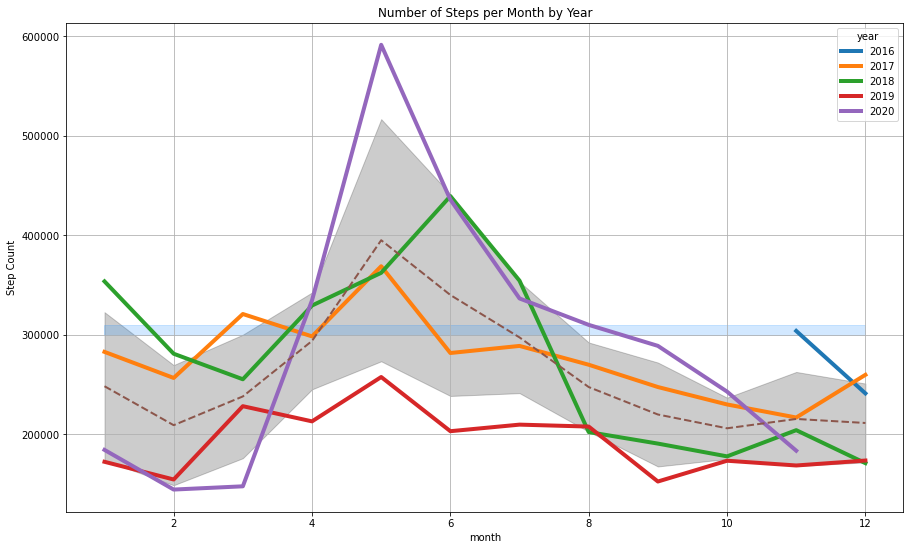

year,2016,2017,2018,2019,2020,monthly_avg,monthly_std
month,,,,,,,
1,NaN,282553.0,353444.0,172031.0,183989.0,248004.0,74467.0
2,NaN,256339.0,280683.0,154231.0,144107.0,208840.0,60395.0
3,NaN,320627.0,255004.0,227950.0,147378.0,237740.0,62108.0
4,NaN,298106.0,329140.0,212685.0,334329.0,293565.0,48707.0
5,NaN,368655.0,362051.0,257276.0,591322.0,394826.0,121747.0
6,NaN,281417.0,439161.0,202798.0,435610.0,339746.0,101526.0
7,NaN,288539.0,354120.0,209394.0,336261.0,297078.0,56014.0
8,NaN,269626.0,201919.0,207453.0,309711.0,247177.0,44835.0
9,NaN,247203.0,190330.0,152202.0,288590.0,219581.0,52251.0


In [15]:
# Group data by year in pivot table
df2 = steps_by_date.copy()
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month

df3 = pd.pivot_table(df2, index='month', columns='year', values='Steps', aggfunc='sum')
#Create mean/std
df3['monthly_avg'] = round(df3.mean(axis=1, skipna=True))
df3['monthly_std'] = round(df3.std(axis=1, skipna=True))

chart_title = 'Number of Steps per Month by Year'
ax = df3.iloc[:,:5].plot(kind='line', figsize=[15, 9], linewidth=4, alpha=1, marker='', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)
df3.monthly_avg.plot(linestyle='dashed', alpha=1, linewidth=2)
plt.fill_between(df3.index, df3.monthly_avg-df3.monthly_std, df3.monthly_avg+df3.monthly_std, alpha=0.2, color='k', label="Average")
plt.fill_between(df3.index, 300000,310000, alpha=0.2, color='dodgerblue', label = '10k SPD')

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_title(chart_title)

# print(df3.iloc[:,:5].max())
plt.show()
df3

----

# Weight Data

In [16]:
#import apple data
weight = pd.read_csv("data/BodyMass.csv")
#keep only apple health data (the rest are copies)
weight = weight[weight.sourceName=='Health']
#sort and reindex
weight = weight.sort_values(by='startDate', ignore_index=True)

# parse out date and time elements as EST time
weight['startDate'] = pd.to_datetime(weight['startDate'], utc=True).dt.tz_convert('EST')
weight['endDate'] = pd.to_datetime(weight['endDate'], utc=True).dt.tz_convert('EST')
weight['date'] = weight['startDate'].dt.strftime('%Y-%m-%d')

#drop irrelevant columns and rename value to Weight
weight = weight[['value','date']]
weight.rename(columns={'value':'Weight'}, inplace=True)

In [17]:
#import fitbit weight data
weight2 = pd.read_csv("data/fitbit_weight.csv")

weight2['Date'] = pd.to_datetime(weight2['Date'])
weight2['date'] = weight2['Date'].dt.strftime('%Y-%m-%d')
weight2 = weight2.drop(['Date','BMI'], axis=1)

In [18]:
#merge with fitbit data
weight = pd.concat([weight2,weight], ignore_index=True)
weight = weight.sort_values(['date', 'Weight'])
weight = weight.groupby(['date'])['Weight'].mean().reset_index(name='Weight')

My most recent weight is 167.5, but my lowest was 167.0 on 2020-11-18.

My max weight of 209.2 occured on 2019-12-28. Since then I have lost 41.7 lbs, a rate of 0.9 lbs per week. At that rate, I will hit 165 lbs in 19.7 days.

In the last week I have gained 0.2 lbs.

Most recent 7-day average weight 167.5
Most recent 30-day average weight 168.9
Most recent 6-month average weight 176.2
Most recent 1-year average weight 189.8


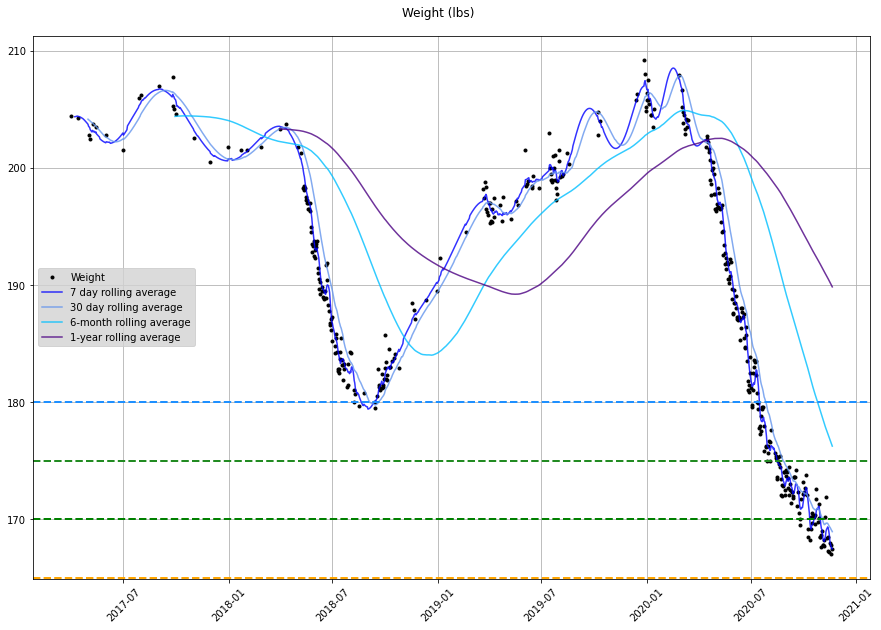

In [19]:
# parse out date and time elements
weight3 = weight.copy()
weight3['Date'] = pd.to_datetime(weight3['date'])

#sort by date and reindex
weight3 = weight3.sort_values(by='Date', ignore_index=True)

#set Date as index
weight3 = weight3.drop('date', axis=1).set_index('Date')

# resample by day and interpolate missing values using splines
weight4 = weight3.resample('D').interpolate(method='spline', order = 4, axis = 0)

#plot it
plt.figure(figsize=[15,10])
ax = plt.gca()
# ax.set_facecolor('whitesmoke')
plt.suptitle('Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight3['Weight'], 'k.', alpha=1,label='Weight')
plt.plot(weight4['Weight'].rolling(window=7, center=False).mean(), c='blue'\
         , alpha=0.8,label='7 day rolling average')
plt.plot(weight4['Weight'].rolling(window=30, center=False).mean(), c='cornflowerblue'\
         , alpha=0.8,label='30 day rolling average')
plt.plot(weight4['Weight'].rolling(window=182, center=False).mean(), c='deepskyblue'\
         , alpha=0.8,label='6-month rolling average')
plt.plot(weight4['Weight'].rolling(window=365, center=False).mean(), c='indigo'\
         , alpha=0.8,label='1-year rolling average')

ax.axhline(180, linewidth=2, color='dodgerblue', linestyle='dashed')#,label="10,000 per day")
ax.axhline(175, linewidth=2, color='forestgreen', linestyle='dashed')#,label="Global avg steps per day")
ax.axhline(170, linewidth=2, color='green', linestyle='dashed')#,label="Global avg steps per day")
ax.axhline(165, linewidth=2, color='orange', linestyle='dashed')#,label="Global avg steps per day")

legend = ax.legend(loc=6, facecolor = 'lightgray')
plt.xticks(rotation=45)


###################
#Start output
###################

# print("My most recent weight {}".format(weight3.Weight[-1]))

if weight3.Weight[-1] <= round(weight4.Weight.min(),1):
    print("My most recent weight is {}, which is my lowest ever!\n".format(weight3.Weight[-1]))
else:
    print("My most recent weight is {}, but my lowest was {} on {}.\n".\
          format(weight3.Weight[-1], round(weight4.Weight.min(),1),\
                 weight4.index[weight4.Weight.argmin()].strftime('%Y-%m-%d')))
    
if weight3.Weight[-1]>180:
    print("My max weight of {} occured on {}. Since then I have lost {} lbs, a rate of {} lbs per week. At that rate, I will hit 180 lbs in {} days.\n"\
     .format(round(weight4.Weight.max(),1),\
             weight4.index[weight4.Weight.argmax()].strftime('%Y-%m-%d'),\
             round((weight4.Weight.max()-weight4.Weight[-1]), 1),\
             round((weight4.Weight.max()-weight4.Weight[-1])/((weight4.shape[0]-weight4.Weight.argmax())/7),1),\
             round((weight3.Weight[-1]-180)/((weight4.Weight.max()-weight4.Weight[-1])/((weight4.shape[0]-weight4.Weight.argmax()))),1)))

elif weight3.Weight[-1]>175:
    print("My max weight of {} occured on {}. Since then I have lost {} lbs, a rate of {} lbs per week. At that rate, I will hit 175 lbs in {} days.\n"\
     .format(round(weight4.Weight.max(),1),\
             weight4.index[weight4.Weight.argmax()].strftime('%Y-%m-%d'),\
             round((weight4.Weight.max()-weight4.Weight[-1]), 1),\
             round((weight4.Weight.max()-weight4.Weight[-1])/((weight4.shape[0]-weight4.Weight.argmax())/7),1),\
             round((weight3.Weight[-1]-175)/((weight4.Weight.max()-weight4.Weight[-1])/((weight4.shape[0]-weight4.Weight.argmax()))),1)))

elif weight3.Weight[-1]>170:
    print("My max weight of {} occured on {}. Since then I have lost {} lbs, a rate of {} lbs per week. At that rate, I will hit 170 lbs in {} days.\n"\
     .format(round(weight4.Weight.max(),1),\
             weight4.index[weight4.Weight.argmax()].strftime('%Y-%m-%d'),\
             round((weight4.Weight.max()-weight4.Weight[-1]), 1),\
             round((weight4.Weight.max()-weight4.Weight[-1])/((weight4.shape[0]-weight4.Weight.argmax())/7),1),\
             round((weight3.Weight[-1]-170)/((weight4.Weight.max()-weight4.Weight[-1])/((weight4.shape[0]-weight4.Weight.argmax()))),1)))
else:
    print("My max weight of {} occured on {}. Since then I have lost {} lbs, a rate of {} lbs per week. At that rate, I will hit 165 lbs in {} days.\n"\
     .format(round(weight4.Weight.max(),1),\
             weight4.index[weight4.Weight.argmax()].strftime('%Y-%m-%d'),\
             round((weight4.Weight.max()-weight4.Weight[-1]), 1),\
             round((weight4.Weight.max()-weight4.Weight[-1])/((weight4.shape[0]-weight4.Weight.argmax())/7),1),\
             round((weight3.Weight[-1]-165)/((weight4.Weight.max()-weight4.Weight[-1])/((weight4.shape[0]-weight4.Weight.argmax()))),1)))


if weight4.Weight[-1]<=weight4.Weight[-8]:
    print("In the last week I have lost {} lbs.\n".format(round(weight4.Weight[-8]-weight4.Weight[-1],3)))
else:
    print("In the last week I have gained {} lbs.\n".format(round(weight4.Weight[-1]-weight4.Weight[-8],3)))

print("Most recent 7-day average weight {}".format(round(weight4['Weight']\
                                                         .rolling(window=7, center=False).mean()[-1],1)))
print("Most recent 30-day average weight {}".format(round(weight4['Weight']\
                                                          .rolling(window=30, center=False).mean()[-1],1)))
print("Most recent 6-month average weight {}".format(round(weight4['Weight']\
                                                           .rolling(window=182, center=False).mean()[-1],1)))
print("Most recent 1-year average weight {}".format(round(weight4['Weight']\
                                                          .rolling(window=365, center=False).mean()[-1],1)))

# print(weight3.tail(10))
# print(weight4.tail(10))

plt.show()

----

## Workout data 

In [20]:
Workout = pd.read_csv("data/Workout.csv")

# parse out date and time elements as EST time
Workout['startDate'] = pd.to_datetime(Workout['startDate'], utc=True).dt.tz_convert('EST')
Workout['endDate'] = pd.to_datetime(Workout['endDate'], utc=True).dt.tz_convert('EST')
Workout['date'] = Workout['startDate'].dt.strftime('%Y-%m-%d')

#Clean workout names
Workout['workoutActivityType'] = Workout['workoutActivityType'].str.replace('HKWorkoutActivityType','')

#round some feautures
Workout.duration = round(Workout.duration, 1)
Workout.totalEnergyBurned = round(Workout.totalEnergyBurned, 0)
Workout.totalDistance = round(Workout.totalDistance, 3)

#Delete unnecessary columns
Workout = Workout.drop(['sourceVersion', 'device', 'creationDate', 'durationUnit', 'totalDistanceUnit', 'totalEnergyBurnedUnit'], axis=1)

#drop duplicates
Workout.drop_duplicates(inplace=True) #removes true duplicates
Workout = Workout[Workout.startDate!='2018-06-25 05:20:40-05:00'].reset_index(drop=True)

In [21]:
#Bicycle mileage
Cycling = Workout.copy()
Cycling = Cycling[Cycling.workoutActivityType=='Cycling'][['duration', 'totalDistance', 'totalEnergyBurned','date']].reset_index(drop=True)
Cycling['date'] = pd.to_datetime(Cycling.date)
Cycling['doy'] = Cycling.date.dt.dayofyear
Cycling['Bike_Cost_Per_Mile'] = 1100/Cycling.totalDistance.cumsum()
Cycling['Bike_Cost_Per_Ride'] = 1100/np.linspace(1,Cycling.shape[0], num=Cycling.shape[0])

# Ghost_price = 1100
# print(Cycling['Bike_Cost_Per_Mile'])
# print(Cycling['Bike_Cost_Per_Ride'])

Cycling.drop_duplicates(subset=['totalDistance','date'], keep='first', inplace=True)
# data.drop_duplicates(subset ="First Name", 
#                      keep = False, inplace = True) 

Cycling['TotalMilesRidden'] = Cycling.totalDistance.cumsum()

# print(Cycling)
Cycling
# print(Cycling.totalDistance.cumsum())
# print(Cycling[Cycling[['totalDistance','date']].duplicated()])

,duration,totalDistance,totalEnergyBurned,date,doy,Bike_Cost_Per_Mile,Bike_Cost_Per_Ride,TotalMilesRidden
0,58.5,6.704,367.0,2018-06-18,169,164.081146,1100.000000,6.704
1,69.9,8.186,420.0,2018-06-22,173,73.875084,550.000000,14.890
2,49.4,5.869,0.0,2018-06-25,176,52.989065,366.666667,20.759
3,83.5,10.045,0.0,2018-06-28,179,35.709648,275.000000,30.804
4,91.2,10.474,700.0,2018-07-02,183,26.648578,220.000000,41.278
...,...,...,...,...,...,...,...,...
119,59.9,20.380,581.0,2020-11-09,314,0.797907,9.166667,1378.607
120,60.0,20.520,686.0,2020-11-11,316,0.786205,9.090909,1399.127
121,59.9,20.420,680.0,2020-11-12,317,0.774895,9.016393,1419.547
122,44.9,15.520,475.0,2020-11-16,321,0.766515,8.943089,1435.067


In [22]:
# # #plot 
# # plt.figure(figsize=[15,10])
# # ax = plt.gca()
# # ax.set_facecolor('whitesmoke')

# # # ax2 = ax.twinx()

# # plt.suptitle('Total Cycling Mileage on "The Ghost"', fontsize=14, y=.92)
# # plt.grid(True)
# # plt.plot(Cycling.date, Cycling.totalDistance.cumsum(), alpha=1, linewidth=2, label='Total Miles Ridden')
# # # ax2.plot(Cycling.date, Cycling.Bike_Cost, alpha=1, linewidth=2, label='$ per Mile')

# # plt.xlabel('Day of Year')
# # plt.ylabel('Miles')
# # # ax2.set_ylabel('Dollars per Mile')
# # plt.xticks(rotation=45)
# # plt.legend(loc=9)
# # plt.show()


# fig, ax1 = plt.subplots(figsize=[15,10])
# ax1.set_xlabel('Day of Year')
# ax1.set_ylabel('Miles Ridden', color='tab:red')
# ax1.plot(Cycling.date, Cycling.totalDistance.cumsum(), alpha=1, linewidth=2, label='Total Miles Ridden', color='tab:red')
# ax1.tick_params(axis='y', labelcolor='tab:red')

# # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# # ax2.set_ylabel('Dollars per Mile', color='tab:green')
# # ax2.plot(Cycling.date, Cycling.Bike_Cost_Per_Mile, alpha=1, linewidth=2, label='$ per Mile', color='tab:green')
# # ax2.tick_params(axis='y', labelcolor='tab:green')

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel('Dollars per Ride', color='tab:blue')
# ax2.plot(Cycling.date, Cycling.Bike_Cost_Per_Ride, alpha=1, linewidth=2, label='$ per Ride', color='tab:blue')
# ax2.tick_params(axis='y', labelcolor='tab:blue')
# # ax2.set_yscale('log')

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# # plt.grid(True)
# plt.show()

# print('Current dollars per ride is {}'.format(round(Cycling.Bike_Cost_Per_Ride.iloc[-1], 2)))
# print('Number of rides {}'.format(Cycling.shape[0]))

In [23]:
#Create df with only walk/run and compute step metrics
Workout2 = Workout.copy()
Workout2['steps'] = np.nan
Workout2 = Workout2[(Workout2.workoutActivityType=='Walking')|(Workout2.workoutActivityType=='Running')]

#Calculate steps during activity taking max of phone/watch measurements
steps1 = steps[steps.sourceName=='Greg’s Apple\xa0Watch']
steps2 = steps[steps.sourceName=='Greg Ames’s iPhone']
for index, row in Workout2.iterrows():
    x1 = steps1[(steps1.startDate>=Workout2.startDate[index])\
              & (steps1.endDate<=Workout2.endDate[index])]
    x2 = steps2[(steps2.startDate>=Workout2.startDate[index])\
              & (steps2.endDate<=Workout2.endDate[index])]
    Workout2.loc[index, 'steps'] = max(x1.value.sum(), x2.value.sum())
      
Workout2['Steps_perMile'] = Workout2.steps/Workout2.totalDistance

#filter out SPM outliers
thresh = 1.5

iqrW = Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.quantile(.75)\
- Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.quantile(.25)
l_limitW = Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.quantile(.25) - thresh * iqrW
u_limitW = Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.quantile(.75) + thresh * iqrW

iqrR = Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.quantile(.75)\
- Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.quantile(.25)
l_limitR = Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.quantile(.25) - thresh * iqrR
u_limitR = Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.quantile(.75) + thresh * iqrR

for index, row in Workout2.iterrows():
    if Workout2.workoutActivityType[index]=='Walking':
        if (Workout2.Steps_perMile[index]<l_limitW)|(Workout2.Steps_perMile[index]>u_limitW):
            Workout2.drop(index, inplace=True)
    elif Workout2.workoutActivityType[index]=='Running':
        if (Workout2.Steps_perMile[index]<l_limitR)|(Workout2.Steps_perMile[index]>u_limitR):
            Workout2.drop(index, inplace=True)
            
Workout2 = Workout2.reset_index(drop=True)

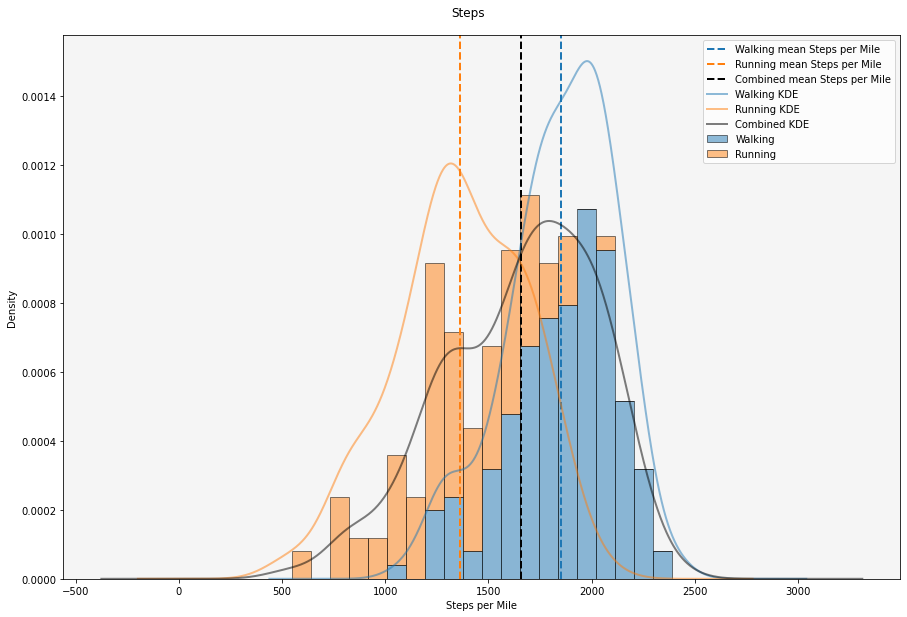

In [24]:
#Specify distribution parameters
bn = 20

#plot histogram of steps
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
n, bins, patches = plt.hist([Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile,\
                             Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile], bn, density=True, alpha =0.5, histtype='barstacked', label=['Walking', 'Running'], edgecolor='black')

ax.axvline(Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.mean(),\
           linewidth=2, color='tab:blue', linestyle='dashed',label="Walking mean Steps per Mile")
ax.axvline(Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.mean(),\
           linewidth=2, color='tab:orange', linestyle='dashed',label="Running mean Steps per Mile")
ax.axvline(Workout2.Steps_perMile.mean(),\
           linewidth=2, color='k', linestyle='dashed',label="Combined mean Steps per Mile")

Workout2[Workout2.workoutActivityType=='Walking'].Steps_perMile.plot.kde(c='tab:blue', alpha = 0.5, linewidth=2, label = 'Walking KDE')
Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.plot.kde(c='tab:orange', alpha = 0.5, linewidth=2, label = 'Running KDE')
Workout2.Steps_perMile.plot.kde(c='k', alpha = 0.5, linewidth=2, label = 'Combined KDE')

# df[df.date.dt.year==2018].Steps.plot.kde(c='tab:green', alpha = 0.5, linewidth=2, label = '2018 KDE')
# df[df.date.dt.year==2019].Steps.plot.kde(c='tab:red', alpha = 0.5, linewidth=2, label = '2019 KDE')

plt.xlabel('Steps per Mile')
plt.legend(loc=1)
plt.show()

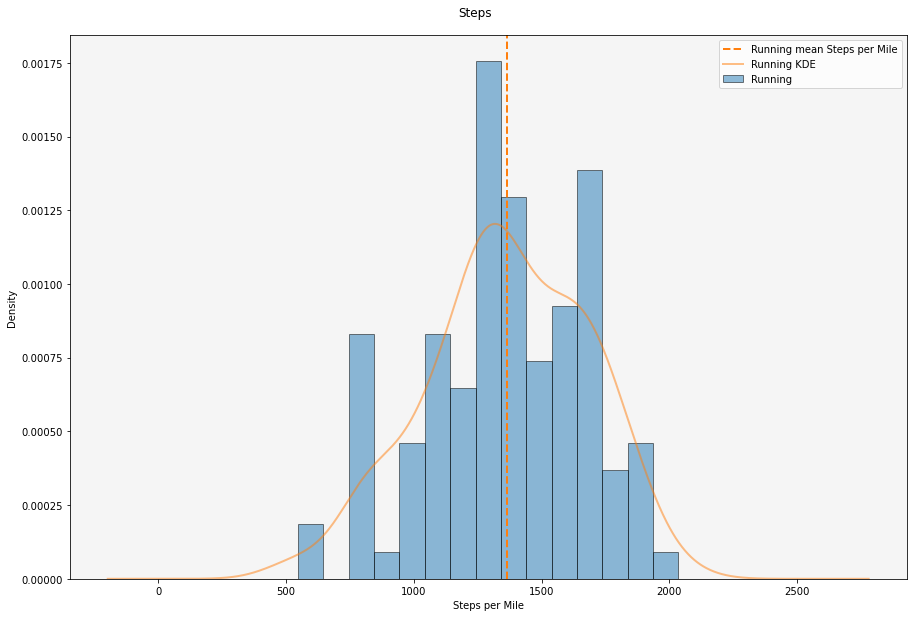

In [25]:
#Specify distribution parameters
bn = 15

#plot histogram of steps
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
n, bins, patches = plt.hist(Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile, bn, density=True, alpha =0.5, label='Running', edgecolor='black')

ax.axvline(Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.mean(),\
           linewidth=2, color='tab:orange', linestyle='dashed',label="Running mean Steps per Mile")

Workout2[Workout2.workoutActivityType=='Running'].Steps_perMile.plot.kde(c='tab:orange', alpha = 0.5, linewidth=2, label = 'Running KDE')

plt.xlabel('Steps per Mile')
plt.legend(loc=1)
plt.show()

Walking - coefficient of determination: 0.9838751787161948
Walking - intercept: 0.4122181940782035
Walking - slope: [0.00046024]
Walking pace is [2172.8] steps per mile.

Running - coefficient of determination: 0.9539371135434448
Running - intercept: 1.1176874646801216
Running - slope: [0.00053946]
Running pace is [1853.7] steps per mile.



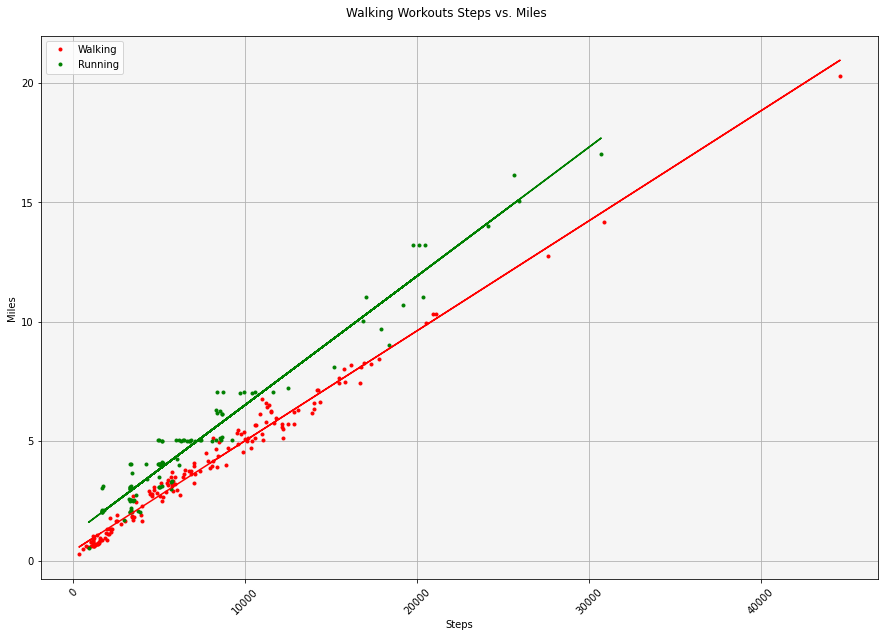

In [26]:
# Fit regression model for walking
x1 = Workout2[Workout2.workoutActivityType=='Walking'].steps.values.reshape((-1, 1))
y1 = Workout2[Workout2.workoutActivityType=='Walking'].totalDistance
model = LinearRegression(fit_intercept=True).fit(x1, y1)
r_sq = model.score(x1, y1)
y_pred = model.predict(x1)
print('Walking - coefficient of determination:', r_sq)
print('Walking - intercept:', model.intercept_)
print('Walking - slope:', model.coef_)
print('Walking pace is {} steps per mile.\n'.format(np.round(1/model.coef_,1)))

# Fit regression model for running
x2 = Workout2[Workout2.workoutActivityType=='Running'].steps.values.reshape((-1, 1))
y2 = Workout2[Workout2.workoutActivityType=='Running'].totalDistance
model2 = LinearRegression(fit_intercept=True).fit(x2, y2)
r_sq2 = model2.score(x2, y2)
y_pred2 = model2.predict(x2)
print('Running - coefficient of determination:', r_sq2)
print('Running - intercept:', model2.intercept_)
print('Running - slope:', model2.coef_)
print('Running pace is {} steps per mile.\n'.format(np.round(1/model2.coef_,1)))

#plot 
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Walking Workouts Steps vs. Miles', fontsize=12, y=.92)
plt.grid(True)
plt.plot(Workout2[Workout2.workoutActivityType=='Walking'].steps,\
         Workout2[Workout2.workoutActivityType=='Walking'].totalDistance, 'r.', alpha=1, label = 'Walking')
plt.plot(Workout2[Workout2.workoutActivityType=='Running'].steps,\
         Workout2[Workout2.workoutActivityType=='Running'].totalDistance, 'g.', alpha=1, label = 'Running')
plt.plot(x1,y_pred, 'r')
plt.plot(x2,y_pred2, 'g')
plt.legend(loc=2)
plt.xticks(rotation=45)
plt.xlabel('Steps')
plt.ylabel('Miles')
plt.show()

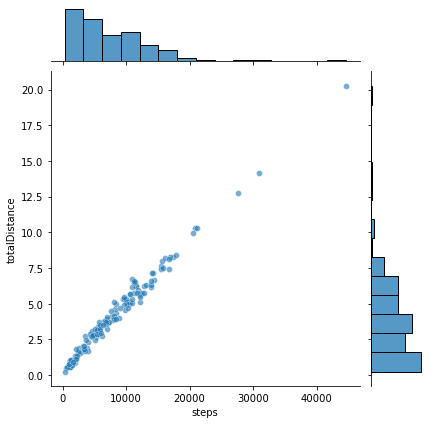

In [27]:
grid = sns.jointplot(x=Workout2[Workout2.workoutActivityType=='Walking'].steps,\
         y=Workout2[Workout2.workoutActivityType=='Walking'].totalDistance, alpha=0.6);
# grid.ax_joint.set_aspect('equal')

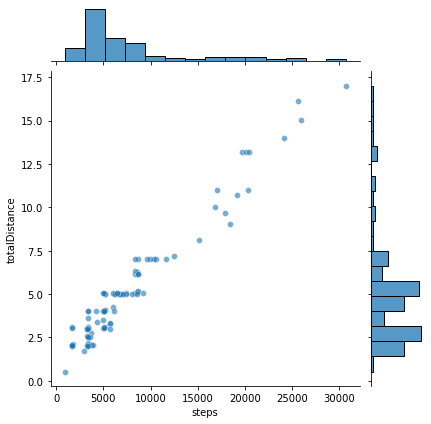

In [28]:
grid = sns.jointplot(x=Workout2[Workout2.workoutActivityType=='Running'].steps,\
         y=Workout2[Workout2.workoutActivityType=='Running'].totalDistance, alpha=0.6);
# grid.ax_joint.set_aspect('equal')

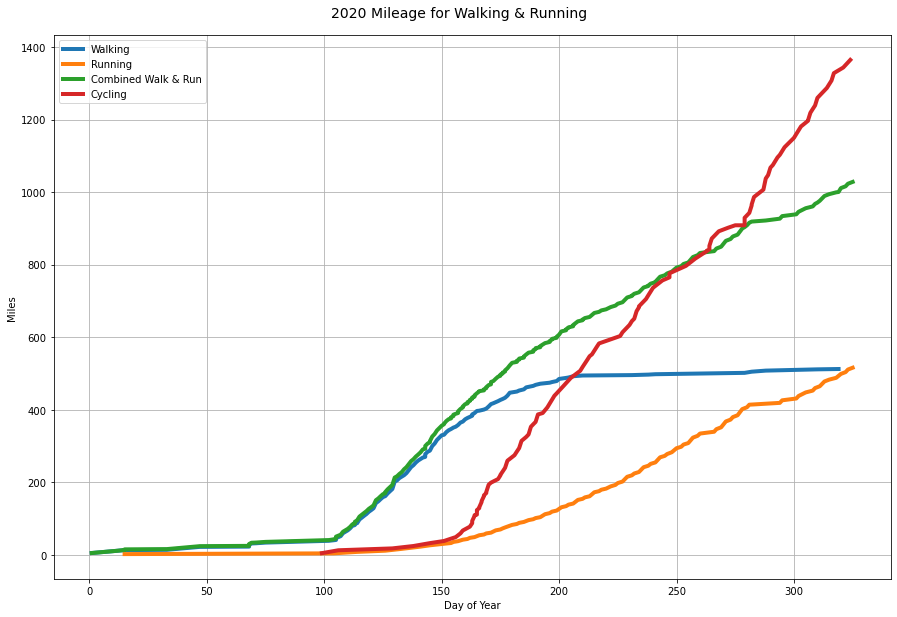

In [29]:
# Cumulative exercise mileage for the year
Workout2['date'] = pd.to_datetime(Workout2['date'])
Workout3 = Workout2[Workout2.date.dt.year==2020].copy().reset_index(drop=True)
Workout3['doy'] = Workout3['date'].dt.dayofyear
Workout3 = Workout3.set_index('doy')

#plot 
plt.figure(figsize=[15,10])
ax = plt.gca()
# ax.set_facecolor('whitesmoke')

plt.suptitle('2020 Mileage for Walking & Running', fontsize=14, y=.92)
plt.grid(True)
plt.plot(Workout3[Workout3['workoutActivityType'] == 'Walking'].totalDistance.cumsum(),\
         alpha=1, label = 'Walking', linewidth=4)
plt.plot(Workout3[Workout3['workoutActivityType'] == 'Running'].totalDistance.cumsum(),\
         alpha=1, label = 'Running', linewidth=4)
plt.plot(Workout3.totalDistance.cumsum(), alpha=1, label = 'Combined Walk & Run', linewidth=4)
plt.plot(Cycling[Cycling.date.dt.year==2020].doy,\
         Cycling[Cycling.date.dt.year==2020].totalDistance.cumsum(), alpha=1, label = 'Cycling', linewidth=4)
plt.legend(loc=2)
plt.xlabel('Day of Year')
plt.ylabel('Miles')
plt.show()

In [30]:
#### Fit regression model for walking
x1 = Workout2[Workout2.workoutActivityType=='Walking'].totalEnergyBurned.values.reshape((-1, 1))
y1 = Workout2[Workout2.workoutActivityType=='Walking'].steps
model = LinearRegression(fit_intercept=True).fit(x1, y1)
r_sq = model.score(x1, y1)
y_pred = model.predict(x1)
print('Walking - coefficient of determination:', r_sq)
print('Walking - intercept:', model.intercept_)
print('Walking - slope:', model.coef_[0])
print('Burn rate is {} calories per step.\n'.format(np.round(1/model.coef_[0],2)))

# Fit regression model for running
x2 = Workout2[Workout2.workoutActivityType=='Running'].totalEnergyBurned.values.reshape((-1, 1))
y2 = Workout2[Workout2.workoutActivityType=='Running'].steps
model2 = LinearRegression(fit_intercept=True).fit(x2, y2)
r_sq2 = model2.score(x2, y2)
y_pred2 = model2.predict(x2)
print('Running - coefficient of determination:', r_sq2)
print('Running - intercept:', model2.intercept_)
print('Running - slope:', model2.coef_[0])
print('Burn rate is {} calories per step.\n'.format(np.round(1/model2.coef_[0],2)))

# Fit regression single model, multivariate
x3 = Workout2[['totalEnergyBurned', 'duration']].values#.reshape((-1, 1))
poly = PolynomialFeatures(interaction_only=True,include_bias = False) #Create interaction terms
x3b = poly.fit_transform(x3)
y3 = Workout2.steps
model3 = LinearRegression(fit_intercept=True).fit(x3b, y3)
r_sq3 = model3.score(x3b, y3)
y_pred3 = model3.predict(x3b)
print('All - coefficient of determination:', r_sq3)
print('All - intercept:', model3.intercept_)
print('All - slopes:', model3.coef_)
print('For a workout of average duration ({} minutes), the burn rate is {} calories per step.\n'\
      .format(round(Workout2.duration.mean(),1),\
              round(1/(model3.coef_[0] + model3.coef_[2]*Workout2.duration.mean()),2)))

# Fit regression running, multivariate
Tdata = Workout2[Workout2.workoutActivityType=='Running']

x4 = Tdata[['totalEnergyBurned', 'duration']].values#.reshape((-1, 1))
poly2 = PolynomialFeatures(interaction_only=True,include_bias = False) #Create interaction terms
x4b = poly2.fit_transform(x4)
y4 = Tdata.steps
model4 = LinearRegression(fit_intercept=True).fit(x4b, y4)
r_sq4 = model4.score(x4b, y4)
y_pred4 = model4.predict(x4b)
print('Running2 - coefficient of determination:', r_sq4)
print('Running2 - intercept:', model4.intercept_)
print('Running2 - slopes:', model4.coef_)
print('For a workout of average duration ({} minutes), the burn rate is {} calories per step.\n'\
      .format(round(Tdata.duration.mean(),1),\
              round(1/(model4.coef_[0] + model4.coef_[2]*Tdata.duration.mean()),2)))




# print('Burn rate is {} calories per step.\n'.format(np.round(1/model3.coef_,1)))

# print(model3)
# print(poly.fit_transform(x3))
# print(round(1/(model3.coef_[0] + model3.coef_[2]*Workout2.duration.mean()),2))
# print(model3.coef_[1]*Workout2.duration.mean()+model3.intercept_)

Walking - coefficient of determination: 0.9303418440153554
Walking - intercept: 634.7050235749766
Walking - slope: 11.52871870995082
Burn rate is 0.09 calories per step.

Running - coefficient of determination: 0.948900389177946
Running - intercept: -1699.2091884466427
Running - slope: 10.866700745742447
Burn rate is 0.09 calories per step.

All - coefficient of determination: 0.9713487682665135
All - intercept: -738.3961336533184
All - slopes: [ 5.44644396e+00  6.82386419e+01 -6.61366318e-04]
For a workout of average duration (65.1 minutes), the burn rate is 0.19 calories per step.

Running2 - coefficient of determination: 0.9650842366266978
Running2 - intercept: -513.9251637385341
Running2 - slopes: [6.11270489e+00 3.74402298e+01 1.27627991e-02]
For a workout of average duration (52.1 minutes), the burn rate is 0.15 calories per step.



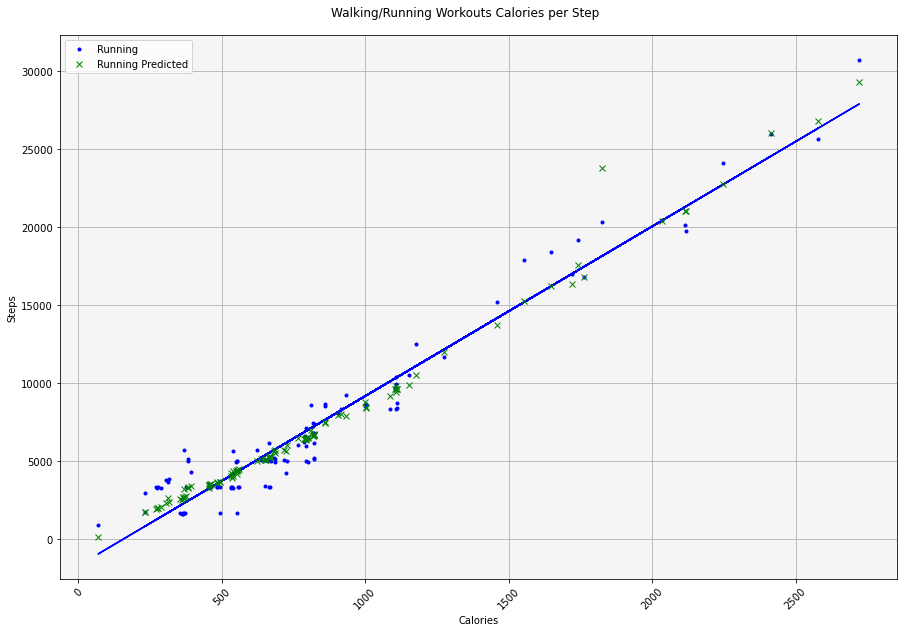

In [31]:
#plot 
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Walking/Running Workouts Calories per Step', fontsize=12, y=.92)
plt.grid(True)
# plt.plot(Workout2[Workout2.workoutActivityType=='Walking'].totalEnergyBurned,\
#          Workout2[Workout2.workoutActivityType=='Walking'].steps, 'r.', alpha=1, label='Walking')
plt.plot(Workout2[Workout2.workoutActivityType=='Running'].totalEnergyBurned,\
         Workout2[Workout2.workoutActivityType=='Running'].steps, 'b.', alpha=1, label='Running')
# plt.plot(x1,y_pred, 'r')
plt.plot(x2,y_pred2, 'b')
# plt.plot(x4,y_pred4, 'g')
# plt.plot(Workout2.totalEnergyBurned,y_pred3, 'k+')
plt.plot(Tdata.totalEnergyBurned,y_pred4, 'gx', label='Running Predicted')
plt.xticks(rotation=45)
plt.xlabel('Calories')
plt.ylabel('Steps')
plt.legend(loc=2)
plt.show()

------

In [32]:
cals = Workout.copy()
cals['date'] = pd.to_datetime(cals['date'])
cals['steps'] = np.nan

#Calculate steps during activity taking max of phone/watch measurements
steps1 = steps[steps.sourceName=='Greg’s Apple\xa0Watch']
steps2 = steps[steps.sourceName=='Greg Ames’s iPhone']
for index, row in cals.iterrows():
    x1 = steps1[(steps1.startDate >= cals.startDate[index])\
              & (steps1.endDate <= cals.endDate[index])]
    x2 = steps2[(steps2.startDate >= cals.startDate[index])\
              & (steps2.endDate <= cals.endDate[index])]
    cals.loc[index, 'steps'] = max(x1.value.sum(), x2.value.sum())

cals = cals[['date', 'workoutActivityType', 'duration', 'totalDistance', 'totalEnergyBurned', 'steps']]

# Set incorrect zero values to null
cals.totalDistance.replace(0,np.nan, inplace=True)
cals.steps.replace(0,np.nan, inplace=True)
cals.totalEnergyBurned.replace(0,np.nan, inplace=True)

# Fill missing cycle calorie counts using model
#cals per minute
x = cals[cals.workoutActivityType=='Cycling'].totalEnergyBurned/cals[cals.workoutActivityType=='Cycling'].duration
#cals per mile
y = cals[cals.workoutActivityType=='Cycling'].totalEnergyBurned/cals[cals.workoutActivityType=='Cycling'].totalDistance
#replace with average
z = round(np.maximum(cals.duration*x.mean(), cals.totalDistance*y.mean()))
cals.totalEnergyBurned.fillna(z, inplace=True)


# print(cals)
# print(cals[cals[['totalEnergyBurned', 'duration']].isnull().any(axis=1)])

#Calculate caloric steps equivalent
cals['CSEfit'] = round(pd.Series(model3.predict(poly.fit_transform(cals[['totalEnergyBurned', 'duration']].values))))

cals['CSE'] = np.where(cals['workoutActivityType'].isin(['Walking', 'Running', 'Tennis']),cals['steps'],cals['CSEfit'])
cals['CSEdiff'] = cals['CSE'] - cals['steps']
# print(cals.head(30))
# print(cals.tail(30))
print(cals[cals.date>='2020-01-01'])
print(cals[cals.date>='2020-01-01'].CSEdiff.sum())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# print(cals.steps.sum())
# print(cals.CSE.sum())

df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])

#Aggregate cals by date
cals2 = cals[['date', 'CSEdiff']].groupby(['date']).sum().reset_index()

df2 = pd.merge(df, cals2, on='date', how='outer')
df2['steps'] = df2[['Steps', 'CSEdiff']].sum(axis=1,skipna=True)
df2.sort_values('date', inplace=True)
df2.drop(['Steps', 'CSEdiff'], axis =1,inplace=True)

# print(df.head())


df2['date'] = pd.to_datetime(df2['date'])
df2['days_elapsed'] = (df2['date']-df2['date'].min()).dt.days +1
df2['steps_expected'] = df2['days_elapsed']*10000
df2['steps_total'] = df2['steps'].cumsum()
df2['steps_deficit'] = df2['steps_expected'] - df2['steps_total']
df2['year'] = df2['date'].dt.year
df2['doy'] = df2['date'].dt.dayofyear
df2['month'] = df2['date'].dt.month
df2=df2.set_index('date')

print(df2.head())
print(df2.tail())
print(df2.steps.sum())
print('I have made up {:,} steps since my largest deficit on {}'\
      .format((df2.iloc[df2.steps_deficit.argmax()].steps_deficit\
               - df2.steps_deficit[-1])\
              , list(df2.index)[df2.steps_deficit.argmax()].strftime('%Y-%m-%d')))


In [ ]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('steps', fontsize=12, y=.92)
plt.grid(True)
plt.plot(df2['steps'], 'r.', alpha=0.2,label='Steps')
plt.plot(df2.steps.rolling(window=7, center=False).mean(), c='k',label='7 day rolling average', alpha=0.75)
plt.plot(df2.steps.rolling(window=365, center=False).mean(), c='blue', label='1-yr rolling avg', alpha =0.75)

ax.axhline(10000, linewidth=2, color='k', linestyle='dashed',label="10,000 per day")
ax.axhline(df2.steps.mean(), linewidth=2, color='blue', linestyle='dashed',label="Global avg steps per day")

plt.hlines(df2.resample('Y').mean()\
           .iloc[0,0],df2.index.min(), df2.resample('Y').mean()\
           .index[0], colors=(1,0,0,1), linewidths=(5,))
plt.hlines(df2.resample('Y').mean()\
           .iloc[1,0],df2.resample('Y').mean().index[0],\
           df2.resample('Y').mean().index[1], colors=(1,0.5,0,1), linewidths=(5,))
plt.hlines(df2.resample('Y').mean()\
           .iloc[2,0], df2.resample('Y').mean().index[1],\
           df2.resample('Y').mean().index[2], colors=(1,1,0,1), linewidths=(5,))
plt.hlines(df2.resample('Y').mean()\
           .iloc[3,0], df2.resample('Y').mean().index[2],\
           df2.resample('Y').mean().index[3], colors=(0.5,1,0,1), linewidths=(5,))
plt.hlines(df2.resample('Y').mean()\
           .iloc[4,0], df2.resample('Y').mean().index[3],\
           df2.index.max(), colors=(0,1,1,1), linewidths=(5,))
plt.legend(loc=2)
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps - Expected/Total/Deficit', fontsize=12, y=.92)
plt.grid(True)
plt.plot(df2['steps_total'], alpha=1,label='Total Steps', linewidth=4, c='blue')
plt.plot(df2['steps_expected'], alpha=1,label='Expected Steps (10K)', linewidth=4, c='r')
plt.plot(df2['steps_deficit'], alpha=1,label='Deficit', linewidth=4, c='green')
ax.fill_between(df2.index, df2['steps_total'], df2['steps_deficit'], facecolor='blue', alpha=0.25)
ax.fill_between(df2.index, df2['steps_expected'], df2['steps_total'], facecolor='r', alpha=0.25)
ax.fill_between(df2.index, df2['steps_deficit'], facecolor='green', alpha=0.25)
plt.yscale('log')
plt.ylabel("Steps")
plt.legend(loc=2)
plt.xticks(rotation=45)
plt.show()

print('My current deficit is {:,} steps'.format(df2.steps_deficit[-1]))

In [ ]:
# df = steps_by_date.copy()
# df2['date'] = pd.to_datetime(df2['date'])
# df2['year'] = df2['date'].dt.year
# df2['doy'] = df2['date'].dt.dayofyear

steps_by_year = pd.pivot_table(df2, index='doy', columns='year', values='steps'\
                               , aggfunc='sum').reset_index().rename_axis(None, axis=1)

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Cumulative Steps by Year', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_year[2016].cumsum(), label='2016', linewidth=4)
plt.plot(steps_by_year[2017].cumsum(), label='2017', linewidth=4)
plt.plot(steps_by_year[2018].cumsum(), label='2018', linewidth=4)
plt.plot(steps_by_year[2019].cumsum(), label='2019', linewidth=4)
plt.plot(steps_by_year[2020].cumsum(), label='2020', linewidth=4)
x1, y1 = [0,366], [0,3660000]
plt.plot(x1,y1, linewidth = 4, linestyle='dashed', c='k')
ax.axvline(189, linewidth=1, color='r', linestyle='dashed', alpha=0.5, label="10,000 per day")
plt.ylabel("Total Steps")
plt.xlabel("Day of Year")
plt.legend(loc=2)
plt.show()

In [ ]:
### Steps needed to get on track

#Yearly averages
# yearly_totals = steps_by_date.copy()
# yearly_totals['date']=pd.to_datetime(yearly_totals['date'])
# yearly_totals=yearly_totals.set_index('date')
yearly_totals =df2['steps'].resample('Y').sum()
# print(yearly_totals)

# Calc 7-day rolling mean
# zz = steps_by_date.copy()
# zz['date']=pd.to_datetime(zz['date'])
# zz=zz.set_index('date')
rolling7 = math.floor(df2.iloc[-7:].steps.mean())

#Current DOY
doy = datetime.today().timetuple().tm_yday#.strftime('%Y-%m-%d')

#My birthday doy
bday_doy = pd.to_datetime('2020-07-07').dayofyear

print("Today is the {}th day of {}.\n".format(doy, yearly_totals.index[-1].year))

print("I am currently averaging {} steps per day (SPD) for {}.\n"\
      .format(math.ceil(yearly_totals.iloc[-1]/doy), yearly_totals.index[-1].year))

# print("I am {} steps behind what I need to be at a 10,000 SPD average.".format((doy*10000-yearly_totals.iloc[-1])))
# print("This is equivalent to being {} days behind.".format(round((doy*10000-yearly_totals.iloc[-1])/10000, 1)))
# print("To reach 10,000 SPD I will need to walk {} SPD for the rest of the year."\
#       .format(math.ceil((3652500-yearly_totals.iloc[-1])/(365.25-doy))))
# print("To reach 10,000 SPD by my birthday I will need to walk {} SPD for the next {} days."\
#       .format(round(((bday_doy*10000)-yearly_totals.iloc[-1])/(bday_doy-doy), 1),\
#               (bday_doy-doy)))

# print("At my current 7-day average of {} I will hit my 10,000 spd average in {} days\n"\
#       .format(rolling7, round((doy*10000-yearly_totals.iloc[-1])/(rolling7-10000),1)))

print("My global average is {} SPD.".format(round(df2.steps.mean(),1)))
# print("I need to make up {:,} steps for my current SPD to match the global average."\
#       .format(math.ceil((steps_by_date2.Steps.mean()-yearly_totals.iloc[-1]/doy)*doy)))
print("To beat my global average I will need to walk {} SPD for the rest of the year."\
      .format(math.ceil(((df2.steps.mean()*365.25)-yearly_totals.iloc[-1])/(365.25-doy))))
print("I need to walk {} extra steps to raise my global average by 1 step."\
      .format((df2.index[-1]-df2.index[0]).days))
print("To reach a global average of 10,000 SPD I need to make up {:,} steps."\
      .format(df2.shape[0]*10000-df2.steps.sum()))
print("At my current 7-day average of {} I will hit a global 10,000 spd average in {} days on {}"\
      .format(rolling7,\
              round((df2.shape[0]*10000-df2.steps.sum())/(rolling7-10000),1),\
             (datetime.today()+ td(days=((df2.shape[0]*10000-df2.steps.sum())/(rolling7-10000)))).strftime('%Y-%m-%d')))


print("Based on my completed step total of {:,}, I have completed 10,000 SPD through {}.\n"\
      .format(df2['steps_total'].iloc[-1],\
              df2.index[int(df2.steps_total.iloc[-1]//10000)].strftime('%Y-%m-%d')))


print("My {} average was {} SPD.".format(yearly_totals.index[1].year, round(yearly_totals.iloc[1]/365.25, 1)))
# print("I need to make up {:,} steps for my current SPD to match {}."\
#       .format(math.ceil((yearly_totals.iloc[1]/365.25-yearly_totals.iloc[-1]/doy)*doy),\
#               yearly_totals.index[1].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year."\
      .format(yearly_totals.index[1].year,\
              math.ceil((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}."\
      .format(math.ceil(yearly_totals.iloc[-1]/doy),\
              yearly_totals.index[1].year,\
              round((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1),\
              math.ceil(doy+(yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}.\n"\
      .format(rolling7,\
              yearly_totals.index[1].year,\
              math.ceil(((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/rolling7)),\
              math.ceil(doy+math.ceil(((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/rolling7)))))

print("My {} average was {} SPD".format(yearly_totals.index[2].year, round(yearly_totals.iloc[2]/365.25, 1)))
# print("I need to make up {:,} steps for my current SPD to match {}."\
#       .format(math.ceil((yearly_totals.iloc[2]/365.25-yearly_totals.iloc[-1]/doy)*doy),\
#               yearly_totals.index[2].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year."\
      .format(yearly_totals.index[2].year,\
              math.ceil((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}."\
      .format(math.ceil(yearly_totals.iloc[-1]/doy),\
              yearly_totals.index[2].year,\
              round((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1),\
              math.ceil(doy+(yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}.\n"\
      .format(rolling7,\
              yearly_totals.index[2].year,\
              math.ceil(((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/rolling7)),\
              math.ceil(doy+math.ceil(((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/rolling7)))))


print("My {} average was {} SPD".format(yearly_totals.index[3].year, round(yearly_totals.iloc[3]/365.25, 1)))
# print("I need to make up {:,} steps for my current SPD to match {}."\
#       .format(math.ceil((yearly_totals.iloc[3]/365.25-yearly_totals.iloc[-1]/doy)*doy),\
#               yearly_totals.index[3].year))
print("To beat my {} average I will need to walk {} SPD for the rest of the year."\
      .format(yearly_totals.index[3].year,\
              math.ceil((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(365.25-doy))))
print("At my current {} SPD pace I will catch {}'s total in {} days on doy {}."\
      .format(math.ceil(yearly_totals.iloc[-1]/doy),\
              yearly_totals.index[3].year,\
              round((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy),1),\
              math.ceil(doy+(yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(yearly_totals.iloc[-1]/doy))))
print("At my current 7-day avg SPD pace of {} I will catch {}'s total in {} days on doy {}."\
      .format(rolling7,\
              yearly_totals.index[3].year,\
              math.ceil(((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/rolling7)),\
              math.ceil(doy+math.ceil(((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/rolling7)))))

In [ ]:
# Group data by year in pivot table
# df2 = steps_by_date.copy()
# df2['date'] = pd.to_datetime(df2['date'])
# df2['year'] = df2['date'].dt.year


df3 = pd.pivot_table(df2, index='month', columns='year', values='steps', aggfunc='sum')
#Create mean/std
df3['monthly_avg'] = round(df3.mean(axis=1, skipna=True))
df3['monthly_std'] = round(df3.std(axis=1, skipna=True))

chart_title = 'Number of Steps per Month by Year'
ax = df3.iloc[:,:5].plot(kind='line', figsize=[15, 9], linewidth=4, alpha=1, marker='', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)
df3.monthly_avg.plot(linestyle='dashed', alpha=1, linewidth=2)
plt.fill_between(df3.index, df3.monthly_avg-df3.monthly_std, df3.monthly_avg+df3.monthly_std, alpha=0.2, color='k', label="Average")
plt.fill_between(df3.index, 300000,310000, alpha=0.2, color='dodgerblue', label = '10k SPD')

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_title(chart_title)

print(df3.iloc[:,:5].max())

plt.show()

## Heart Rate

### Resting Heart Rate

In [ ]:
resting = pd.read_csv("data/RestingHeartRate.csv")
# print(resting.head())

# parse out date and time elements as EST time
resting['startDate'] = pd.to_datetime(resting['startDate'], utc=True).dt.tz_convert('EST')
resting['date'] = resting['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
resting = resting[['date', 'value']]

# Creating daily average resting HR
resting_daily = resting.copy()
resting_daily = resting_daily.sort_values('date', ignore_index=True)
resting_daily = resting_daily.groupby(['date'])['value'].mean().reset_index(name='Resting_HR')
resting_daily['date'] = pd.to_datetime(resting_daily['date'])
resting_daily = resting_daily.set_index('date')

In [ ]:
#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Resting Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(resting_daily.Resting_HR, 'r.', alpha=0.2,label='Resting HR')
plt.plot(resting_daily.Resting_HR.rolling(window=7, center = False).mean(),\
         c='k',label='7 day rolling average', alpha=1)
plt.plot(resting_daily.Resting_HR.rolling(window=30, center = False).mean(), \
         c='c',label='30 day rolling average', alpha=1)
ax.axhline(resting_daily['Resting_HR'].mean(),\
           label = 'Global Average', linewidth=2, color='k', linestyle='dashed')
plt.legend(loc=2)
plt.xticks(rotation=45)

print('My most recent resting HR is {}'\
      .format(round(resting_daily.Resting_HR.rolling(window=7, center = False).mean()[-1],1)))
print('My most recent resting HR 7-day average is {}'\
      .format(round(resting_daily.Resting_HR.rolling(window=7, center = False).mean()[-1],1)))
print('My most recent resting HR 30-day average is {}'\
      .format(round(resting_daily.Resting_HR.rolling(window=30, center = False).mean()[-1],1)))

plt.show()

### VO2 Max

In [ ]:
vo2 = pd.read_csv("data/VO2Max.csv")
vo2['startDate'] = pd.to_datetime(vo2['startDate'], utc=True).dt.tz_convert('EST')
vo2['date'] = vo2['startDate'].dt.strftime('%Y-%m-%d')

print(vo2.head())

In [ ]:
vo2m = vo2[['date', 'value']].copy()
vo2m = vo2m.groupby(['date'])['value'].max().reset_index(name='vo2max')
vo2m['date'] = pd.to_datetime(vo2m['date'])
vo2m = vo2m.sort_values(by='date', ignore_index=True)
vo2m =vo2m.set_index('date')

# resample by day and interpolate missing values using splines
vo2max = vo2m.resample('D').interpolate(method='spline', order = 4, axis = 0)

# print(vo2m.head())


#plot it
plt.figure(figsize=[15,10])
ax = plt.gca()
# ax.set_facecolor('whitesmoke')
plt.suptitle('VO2 Max', fontsize=12, y=.92)
plt.grid(True)
plt.plot(vo2m['vo2max'], 'k.', alpha=1,label='VO2 Max')
plt.plot(vo2max['vo2max'].rolling(window=7, center=False).mean(), c='blue'\
         , alpha=0.8,label='7 day rolling average')
plt.plot(vo2max['vo2max'].rolling(window=30, center=False).mean(), c='cornflowerblue'\
         , alpha=0.8,label='30 day rolling average')
plt.plot(vo2max['vo2max'].rolling(window=182, center=False).mean(), c='deepskyblue'\
         , alpha=0.8,label='6-month rolling average')
plt.plot(vo2max['vo2max'].rolling(window=365, center=False).mean(), c='indigo'\
         , alpha=0.8,label='1-year rolling average')


plt.xticks(rotation=45)

ax.axhline(45, label = 'Excellent (age 46-55)', linewidth=2, color='tab:green', linestyle='dashed')
ax.axhline(39, label = 'Good (age 46-55)', linewidth=2, color='tab:blue', linestyle='dashed')
ax.axhline(36, label = 'Above average (age 46-55)', linewidth=2, color='k', linestyle='dashed')
# ax.axhline(32, label = 'Average (46)', linewidth=2, color='k', linestyle='dashed')

legend = ax.legend(loc=3, facecolor = 'lightgray')
print("Most recent VO2 Max is {}".format(vo2max.vo2max[-1]))
print("Most recent 7-day average VO2 Max {}".format(round(vo2max['vo2max']\
                                                         .rolling(window=7, center=False).mean()[-1],1)))
print("Most recent 30-day average VO2 Max {}".format(round(vo2max['vo2max']\
                                                          .rolling(window=30, center=False).mean()[-1],1)))
print("Most recent 6-month average VO2 Max {}".format(round(vo2max['vo2max']\
                                                           .rolling(window=182, center=False).mean()[-1],1)))
print("Most recent 1-year average VO2 Max {}".format(round(vo2max['vo2max']\
                                                          .rolling(window=365, center=False).mean()[-1],1)))
plt.show()


### Hourly Heart Rate

In [ ]:
# hr = pd.read_csv("data/HeartRate.csv")

# # parse out date and time elements as EST time
# hr['startDate'] = pd.to_datetime(hr['startDate'], utc=True).dt.tz_convert('EST')
# # hr['date'] = hr['startDate'].dt.strftime('%Y-%m-%d')

# #Delete unnecessary columns
# hr = hr[['startDate', 'value']]

# # hr.head()
# # hr.tail()

In [ ]:
# hr2 = hr.copy()
# hr2 =hr2.sort_values('startDate', ignore_index=True)
# hr2 = hr2.set_index('startDate')
# hr2 = hr2.resample('H').mean()
# hr2 = hr2.resample('H').interpolate(method='linear', axis = 0)

# # print(hr2.head())

# hr2['RollingHR'] = hr2.value.rolling(window=24, center = True).mean()

# #plot resting HR with rolling avg
# plt.figure(figsize=[15,10])
# ax = plt.gca()
# ax.set_facecolor('whitesmoke')

# plt.suptitle('Hourly Heart Rate', fontsize=12, y=.92)
# plt.grid(True)
# plt.plot(hr2['value'], 'r.', alpha=0.1,label='Hourly Heart Rate')
# plt.plot(hr2['RollingHR'], c='k',label='24hr rolling average', alpha=1)

# plt.legend(loc=2)
# plt.xticks(rotation=45)

# plt.show()